In [26]:
import pandas as pd
import plotly.express as px
import numpy as np
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

# Base de dados das ligações

In [27]:
# Leitura dos dados
df = pd.read_csv("calls.csv")

# Conversão do time stamp da data
df["date"] = pd.to_datetime(df.date, format="%d/%m/%Y")
# df["call_started"] = pd.to_datetime(df.call_started, format="%I:%M:%S %p")

In [28]:
df.head()

,call_id,date,daily_caller,call_started,call_answered,call_ended,wait_length,service_length,meets_standard,call_type
0,1,2021-01-01,1,8:00:00 AM,8:00:00 AM,8:14:22 AM,0,863,True,1
1,2,2021-01-01,2,8:02:42 AM,8:02:42 AM,8:07:31 AM,0,289,True,0
2,3,2021-01-01,3,8:08:24 AM,8:08:24 AM,8:10:13 AM,0,108,True,1
3,4,2021-01-01,4,8:09:37 AM,8:09:37 AM,8:13:45 AM,0,247,True,1
4,5,2021-01-01,5,8:11:10 AM,8:11:10 AM,8:15:28 AM,0,258,True,1


O gerente deseja que 90% das chamadas sejam atendidas em até um minuto

In [29]:
# Chamadas que aguardam mais de um minuto (60 segundos)
df.loc[df["wait_length"] > 60].head()

,call_id,date,daily_caller,call_started,call_answered,call_ended,wait_length,service_length,meets_standard,call_type
11,12,2021-01-01,12,8:28:25 AM,8:29:37 AM,8:33:30 AM,72,232,False,1
207,208,2021-01-04,62,1:10:31 PM,1:11:38 PM,1:15:37 PM,67,238,False,1
209,210,2021-01-04,64,1:13:08 PM,1:15:37 PM,1:27:35 PM,149,718,False,1
240,241,2021-01-04,95,3:24:55 PM,3:26:03 PM,3:28:42 PM,68,159,False,2
241,242,2021-01-04,96,3:25:33 PM,3:28:01 PM,3:29:01 PM,148,60,False,1


## Análise anual

In [30]:
# Número de chamadas analisadas
n = len(df)  # 51708

# Chamadas que demoraram mais de um minuto para serem atendidas
falhas = df.loc[df["wait_length"] > 60]
qtd_falhas = len(falhas)  # 4227

# Percentual anual de falhas
print(f"No ano de 2021, em média, {(qtd_falhas / n) * 100 :.2f}% das ligações demoraram mais de 60 segundos para serem atendidas")

No ano de 2021, em média, 8.17% das ligações demoraram mais de 60 segundos para serem atendidas


### Distribuição de ligações

In [31]:
# Quantidade de dias comerciais registrados
len(df["date"].unique())

261

In [32]:
# Agrupando ligações por dia
ligacoes = df.groupby(["date"])["daily_caller"].max()
ligacoes.head()

date
2021-01-01    146
2021-01-04    135
2021-01-05    143
2021-01-06    150
2021-01-07    133
Name: daily_caller, dtype: int64

In [33]:
# Mostra a tendência de ligações por dia ao longo do ano
fig = px.line(ligacoes)
fig.show()

### Estatística descritiva

In [34]:
# Tempo médio de espera
df["wait_length"].describe()

count    51708.000000
mean        17.034927
std         64.060769
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        983.000000
Name: wait_length, dtype: float64

In [35]:
# Boxplot tempo de espera
fig = px.box(df, y="wait_length")
fig.show()

In [36]:
# Tempo médio de serviço
df["service_length"].describe()

count    51708.000000
mean       299.102595
std        299.865751
min          0.000000
25%         86.000000
50%        208.000000
75%        414.000000
max       3110.000000
Name: service_length, dtype: float64

In [37]:
# Boxplot tempo de serviço
fig = px.box(df, y="service_length")
fig.show()

In [38]:
# Save wait times
# np.savetxt(r".\times\wait_times.txt", df["wait_length"].values, fmt='%d')
# Save service times
# np.savetxt(r".\times\service_times.txt", df["service_length"].values, fmt='%d')

#### Fit dos tempos de serviço

In [39]:
fig = px.histogram(df, x="service_length")
fig.show()

Fitting 10 distributions: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
expon,3.228528e-08,2183.934331,-1.453078e+06,inf,0.002908,7.733781e-01
chi2,3.315558e-08,2184.919713,-1.451691e+06,inf,0.006581,2.258019e-02
gamma,3.361879e-08,2185.604830,-1.450974e+06,inf,0.006852,1.549740e-02
exponpow,1.258152e-06,2611.983213,-1.263671e+06,inf,0.049770,9.426228e-112
cauchy,1.139810e-05,2040.311055,-1.149728e+06,inf,0.197659,0.000000e+00


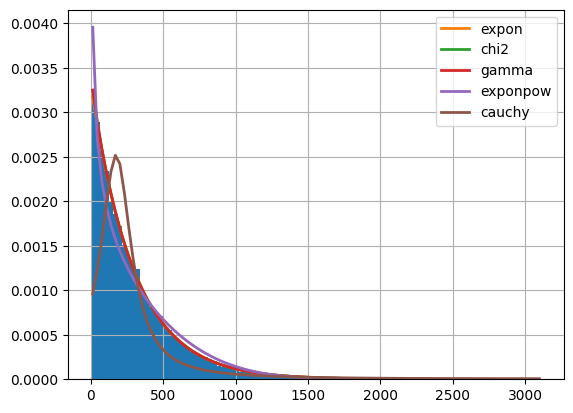

In [40]:
tempos_servico = df["service_length"].values
f = Fitter(tempos_servico, distributions=get_common_distributions())
f.fit()
f.summary()

In [41]:
# Melhor fit para tempos de serviço é exponencial
f.get_best(method = 'sumsquare_error')

{'expon': {'loc': 0.0, 'scale': 299.1025953430804}}

In [42]:
# Exponencial de média 299,1
f.fitted_param["expon"]

(0.0, 299.1025953430804)